In [1]:
# Install extra-dependencies
!pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [3]:
!pip3 install pandas

  Using cached https://files.pythonhosted.org/packages/e7/f9/f0b53f88060247251bf481fa6ea62cd0d25bf1b11a87888e53ce5b7c8ad2/pytz-2019.3-py2.py3-none-any.whl


In [5]:
!pip3 install matplotlib

  Using cached https://files.pythonhosted.org/packages/64/46/75ab48386cbd56065f5542360562be524ad599911455b6d95520cb118613/kiwisolver-1.1.0-cp36-none-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl


In [12]:
!pip3 install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=449490bda57827774b1a760ac4da1f496a7742c50bcec6fbfd44f1a0de29a7a0
  Stored in directory: C:\Users\ktgan\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [6]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [8]:
data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10) 

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-geo', 'O', 'I-per', 'B-tim', 'B-art', 'I-gpe', 'B-nat', 'I-art', 'I-eve', 'I-nat', 'B-org', 'B-geo', 'B-eve', 'I-org', 'I-tim', 'B-gpe', 'B-per']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


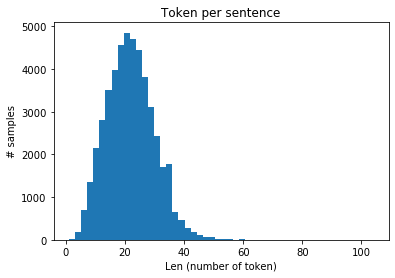

In [10]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [13]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 33081
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 12
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [24359 29436 21411 22061 22206 18264 31078 17398 28289 14789 19265 17491
 20900  3939 20212 14789 22520 29436 24425 13661 26030 16681 13897 33710
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0

In [14]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


g:\ml_space\workspace\ner\test_ner\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
g:\ml_space\workspace\ner\test_ner\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 40)            1407200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 18)            1278      
Total params: 1,449,928
Trainable params: 1,449,928
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)




Train on 38846 samples, validate on 4317 samples
Epoch 1/5





 - 36s - loss: 0.5270 - crf_viterbi_accuracy: 0.8677 - val_loss: 0.2351 - val_crf_viterbi_accuracy: 0.9515
Epoch 2/5
 - 29s - loss: 0.2076 - crf_viterbi_accuracy: 0.9541 - val_loss: 0.1539 - val_crf_viterbi_accuracy: 0.9560
Epoch 3/5
 - 29s - loss: 0.1122 - crf_viterbi_accuracy: 0.9661 - val_loss: 0.0825 - val_crf_viterbi_accuracy: 0.9784
Epoch 4/5
 - 29s - loss: 0.0647 - crf_viterbi_accuracy: 0.9822 - val_loss: 0.0526 - val_crf_viterbi_accuracy: 0.9856
Epoch 5/5
 - 30s - loss: 0.0434 - crf_viterbi_accuracy: 0.9876 - val_loss: 0.0394 - val_crf_viterbi_accuracy: 0.9884


In [16]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [17]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

g:\ml_space\workspace\ner\test_ner\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        40
       B-eve       0.00      0.00      0.00        30
       B-geo       0.78      0.89      0.83      3670
       B-gpe       0.95      0.91      0.93      1586
       B-nat       0.00      0.00      0.00        27
       B-org       0.72      0.63      0.67      1983
       B-per       0.82      0.73      0.77      1712
       B-tim       0.89      0.80      0.84      2033
       I-art       0.00      0.00      0.00        23
       I-eve       0.00      0.00      0.00        16
       I-geo       0.80      0.61      0.69       744
       I-gpe       0.00      0.00      0.00        24
       I-nat       0.00      0.00      0.00         6
       I-org       0.74      0.72      0.73      1577
       I-per       0.80      0.84      0.82      1753
       I-tim       0.85      0.52      0.65       670
           O       0.98      0.99      0.99     88482
         PAD       1.00    

In [18]:
import pickle

# Saving Vocab
with open('models/w1.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Vocab
with open('models/t1.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
model.save_weights('models/tr1.h5')

In [28]:
model.save('models/tr1_m1.h5')

In [23]:
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import  crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

In [24]:
reload_model = load_model('models/tr1_m1.h5', custom_objects={'CRF':CRF, 
                                                  'crf_loss':crf_loss, 
                                                  'crf_viterbi_accuracy':crf_viterbi_accuracy})

In [25]:
reload_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 40)            1407200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 18)            1278      
Total params: 1,449,928
Trainable params: 1,449,928
Non-trainable params: 0
_________________________________________________________________


In [29]:
!tflite_convert --output_file='models/tr1_m1.tflite' --keras_model_file='models/tr1_m1.h5'

2019-12-31 02:19:23.108567: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Traceback (most recent call last):
  File "c:\users\ktgan\appdata\local\programs\python\python36\Lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\ktgan\appdata\local\programs\python\python36\Lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "G:\ML_Space\Workspace\NER\test_ner\Scripts\tflite_convert.exe\__main__.py", line 7, in <module>
  File "g:\ml_space\workspace\ner\test_ner\lib\site-packages\tensorflow_core\lite\python\tflite_convert.py", line 515, in main
    app.run(main=run_main, argv=sys.argv[:1])
  File "g:\ml_space\workspace\ner\test_ner\lib\site-packages\tensorflow_core\python\platform\app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "g:\ml_space\workspace\ner\test_ner\lib\site-packages\absl\app.py", line 299, in r

In [30]:
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

In [33]:
from keras.models import load_model
reload_model = load_model('models/tr1_m1.h5', custom_objects={'CRF':CRF, 
                                                  'crf_loss':crf_loss, 
                                                  'crf_viterbi_accuracy':crf_viterbi_accuracy})
print(reload_model.outputs)
# [<tf.Tensor 'dense_2/Softmax:0' shape=(?, 10) dtype=float32>]
print(reload_model.inputs)
# [<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>]

[<tf.Tensor 'crf_1_2/one_hot:0' shape=(?, ?, 18) dtype=float32>]
[<tf.Tensor 'input_1_4:0' shape=(?, 75) dtype=float32>]


In [34]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in reload_model.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 96 variables.
INFO:tensorflow:Converted 96 variables to const ops.


In [35]:
tf.train.write_graph(frozen_graph, "models", "tf_model1.pb", as_text=False)

'models\\tf_model1.pb'

In [ ]:
!tflite_convert --output_file='models/tfl_model1.tflite' --graph_def_file='models/tf_model1.pb' --input_arrays=embedding_1/embeddings --output_arrays=training_2/RMSprop/Variable_13

In [42]:
gf = tf.GraphDef()   
m_file = open('models/tf_model1.pb','rb')
gf.ParseFromString(m_file.read())

with open('somefile.txt', 'a') as the_file:
    for n in gf.node:
        the_file.write(n.name+'\n')

file = open('somefile.txt','r')
data = file.readlines()
print("output name = ")
print (data[len(data)-1])

print ("Input name = ")
file.seek ( 0 )
print (file.readline())

output name = 
training_2/RMSprop/Variable_13

Input name = 
embedding_1/embeddings

